# Wellflow end-to-end example workflow

. This notebook demonstrates a full pipeline on a clean Gen5 wide dataset:
- Read and normalize measurements
- Blank-correct OD (remove baseline)
- Smooth OD to reduce noise
- Estimate per-time-point growth rate (mu)
- Estimate an early-OD threshold from blanked values
- Summarize mu_max (max growth rate) per well with simple CIs

> We also visualize before/after at each stage to verify behavior.

In [1]:
# Imports and setup
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "src")))  # prefer local source during development

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from wellflow.plate import (
    read_plate_measurements,
    with_blank_corrected_od,
    with_smoothed_od,
    add_growth_rate,
    estimate_early_od_threshold,
    summarize_mu_max,
    # Optional: layout/flagging utilities if needed later
    # read_plate_layout, merge_measurements_and_conditions, add_flag_column, drop_flags,
)

sns.set_context("talk")
sns.set_style("whitegrid")

In [2]:
# File paths (run this notebook from the examples/ folder)
data_path = "example_widedata.xlsx"
print(f"Reading data from: {data_path}")

Reading data from: example_widedata.xlsx


In [3]:
# 1) Read and normalize measurements (Gen5 wide kinetics)
# If your sheet uses different header rows, adjust header_row/last_row/start_col accordingly.
raw = read_plate_measurements(
    "Synergy H1",
    "wide",
    ["Time"],
    data_path,
    # header_row=1, last_row=None, start_col=0,  # defaults; uncomment if needed
)
print("Raw shape:", raw.shape)
raw.head()

Raw shape: (9312, 4)


,time,well,od,time_hours
0,0 days 00:14:04,A1,0.003,0.234444
1,0 days 00:14:04,A10,0.002,0.234444
2,0 days 00:14:04,A11,0.002,0.234444
3,0 days 00:14:04,A12,0.002,0.234444
4,0 days 00:14:04,A2,0.002,0.234444


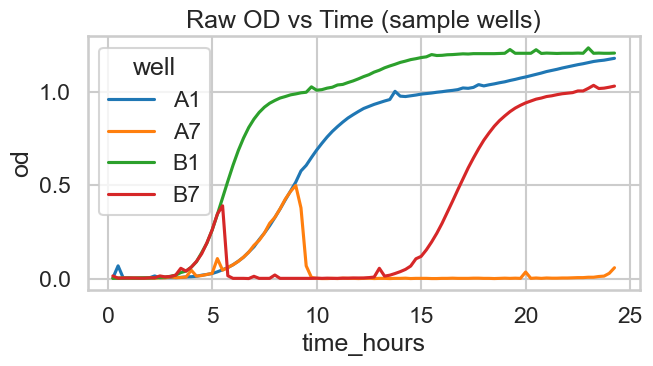

In [4]:
# Preview: Raw OD vs Time for a few wells
wells_to_plot = ["A1", "A7", "B1", "B7"]
mask = raw[raw["well"].isin(wells_to_plot)]
fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(data=mask, x="time_hours", y="od", hue="well", ax=ax)
ax.set_title("Raw OD vs Time (sample wells)")
plt.tight_layout()

Blanked shape: (9312, 5)


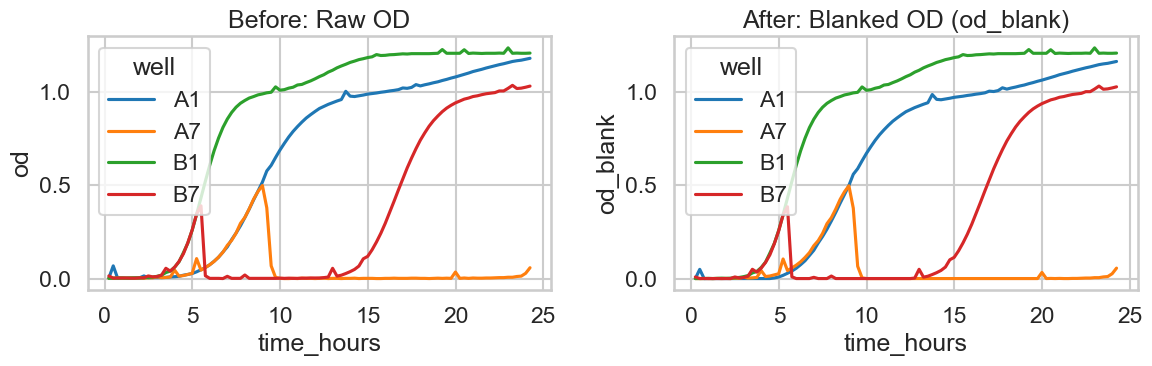

In [5]:
# 2) Blank-correct OD (subtract baseline)
blanked = with_blank_corrected_od(raw, window=4)
print("Blanked shape:", blanked.shape)

mask_b = blanked[blanked["well"].isin(wells_to_plot)]
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True)
axes[0].set_title("Before: Raw OD")
sns.lineplot(data=mask_b, x="time_hours", y="od", hue="well", ax=axes[0])
axes[1].set_title("After: Blanked OD (od_blank)")
sns.lineplot(data=mask_b, x="time_hours", y="od_blank", hue="well", ax=axes[1])
plt.tight_layout()

Smoothed shape: (9312, 6)


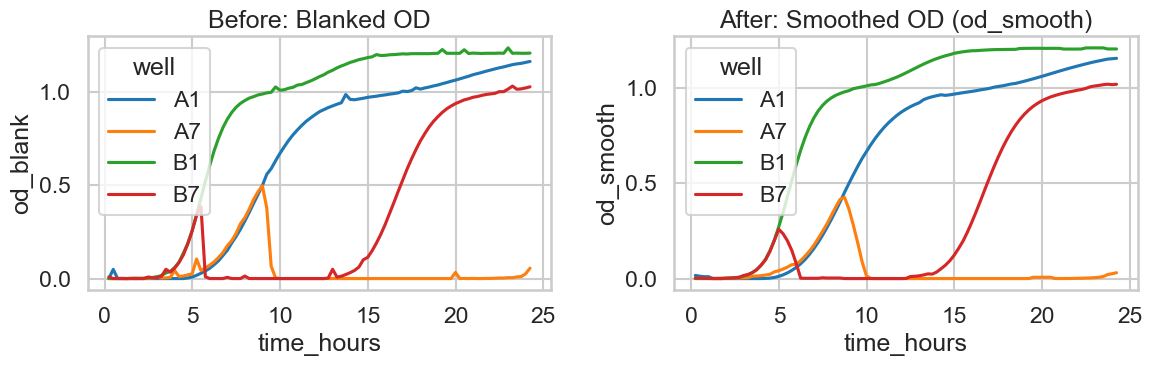

In [6]:
# 3) Smooth OD to reduce noise
smoothed = with_smoothed_od(blanked, window=5)
print("Smoothed shape:", smoothed.shape)

mask_s = smoothed[smoothed["well"].isin(wells_to_plot)]
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True)
axes[0].set_title("Before: Blanked OD")
sns.lineplot(data=mask_s, x="time_hours", y="od_blank", hue="well", ax=axes[0])
axes[1].set_title("After: Smoothed OD (od_smooth)")
sns.lineplot(data=mask_s, x="time_hours", y="od_smooth", hue="well", ax=axes[1])
plt.tight_layout()

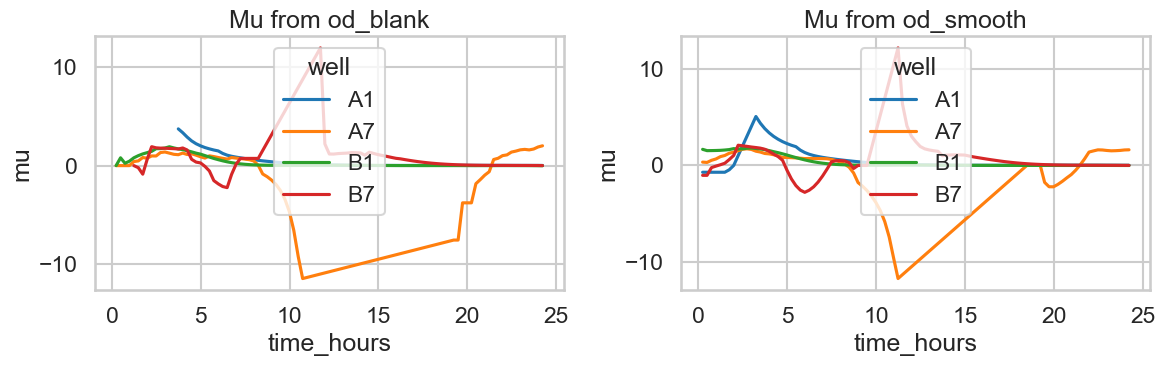

In [7]:
# 4) Growth-rate (mu) per timepoint: compare from od_blank vs od_smooth
with_mu_blank = add_growth_rate(blanked, window=10, od_col="od_blank")
with_mu_smooth = add_growth_rate(smoothed, window=10)  # default od_smooth

mask_mb = with_mu_blank[with_mu_blank["well"].isin(wells_to_plot)]
mask_ms = with_mu_smooth[with_mu_smooth["well"].isin(wells_to_plot)]
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharex=True)
axes[0].set_title("Mu from od_blank")
sns.lineplot(data=mask_mb, x="time_hours", y="mu", hue="well", ax=axes[0])
axes[1].set_title("Mu from od_smooth")
sns.lineplot(data=mask_ms, x="time_hours", y="mu", hue="well", ax=axes[1])
plt.tight_layout()

Estimated early-OD threshold (from od_blank): 0.011762499999999988


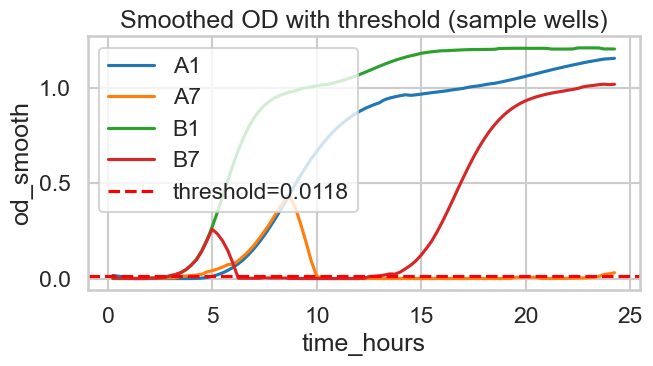

In [8]:
# 5) Estimate threshold from BLANKED OD and show it over smoothed OD
threshold = estimate_early_od_threshold(blanked, od_col="od_blank", n_points=5, q=0.95)
print("Estimated early-OD threshold (from od_blank):", threshold)

fig, ax = plt.subplots(figsize=(7,4))
sns.lineplot(data=mask_s, x="time_hours", y="od_smooth", hue="well", ax=ax)
ax.axhline(threshold, color="red", linestyle="--", label=f"threshold={threshold:.3g}")
ax.legend()
ax.set_title("Smoothed OD with threshold (sample wells)")
plt.tight_layout()

In [9]:
# 6) Summarize mu_max per well using od_smooth and the blank-based threshold
max_mu = summarize_mu_max(with_mu_smooth, window=5, od_col="od_smooth", threshold=threshold)

In [10]:
max_mu[max_mu["well"].isin(wells_to_plot)]

,well,mu_max,mu_low,mu_high,tau,tau_low,tau_high,t_mu_max,t_start,t_end
0,A1,1.377653,1.157293,1.598012,0.503136,0.433756,0.598938,5.734444,5.234444,6.234444
9,A7,1.046145,0.729850,1.362440,0.662573,0.508754,0.949712,4.484444,3.984444,4.984444
12,B1,1.674080,1.661364,1.686797,0.414047,0.410925,0.417216,3.484444,2.984444,3.984444
21,B7,1.552755,1.433001,1.672509,0.446398,0.414436,0.483703,3.734444,3.234444,4.234444


In [11]:
# 7) Quick sanity checks to verify function behavior
assert {"time","well","od"}.issubset(set(raw.columns))
assert (blanked["od_blank"] >= 0).all(), "od_blank should be non-negative"
assert {"od_smooth"}.issubset(set(smoothed.columns))
assert {"mu"}.issubset(set(with_mu_smooth.columns))
# Some wells should have finite mu values at or above threshold
has_mu = with_mu_smooth[with_mu_smooth["od_smooth"] >= threshold]["mu"].dropna()
print("Finite mu count above threshold:", has_mu.shape[0])
assert has_mu.shape[0] > 0, "Expected some finite mu values above threshold"
assert set(max_mu.columns) >= {"well","mu_max","tau"}
print("All checks passed.")

Finite mu count above threshold: 6218
All checks passed.
